# Classifieur bayésien

In [146]:
import pandas as pa
import numpy as np

dataset = pa.read_csv("https://www.labri.fr/perso/zemmari/datasets/salmon_seabass.csv", sep=";")
df = pa.DataFrame(dataset)

df.head()

,lightness,width,species
0,9.710457,8.673699,0
1,6.528089,7.330887,0
2,1.770695,7.599677,0
3,4.819293,7.328198,0
4,6.769638,8.575629,0


In [147]:
# class = data type
# col `species` is class
# 0 : il s'agit d'un saumon
# 1 : il s'agit d'un bar

sizeVTSaumon = np.count_nonzero(df["species"] == 0)
sizeVTBar = np.count_nonzero(df["species"] == 1)

print("Saumon :", sizeVTSaumon, "Bar :", sizeVTBar)

Saumon : 1000 Bar : 500


## Exercice 1

In [148]:
data = df.sample(frac=1)

In [149]:
X = data["width"]
Y = data["species"]

In [150]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
print(len(X_train), str(len(X_train) * 100 / len(X)) + "%")
print(len(X_test), str(len(X_test) * 100 / len(X)) + "%")

1200 80.0%
300 20.0%


### Classifieur ML

In [151]:
# mean is average in statistics (la moyenne)
meanSaumon = np.mean(X_train[Y_train == 0])
meanBar = np.mean(X_train[Y_train == 1])

# l'écart type = standard deviation, the variance : a measure of the spread of a distribution, of the array elements.
stdSaumon = np.std(X_train[Y_train == 0], 0)
stdBar = np.std(X_train[Y_train == 1], 0)
print(meanSaumon, meanBar, stdSaumon, stdBar)

8.032315377653061 12.090888346932058 1.0088489028973928 2.057498676765457


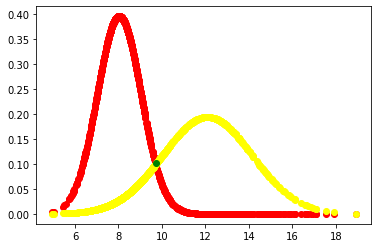

In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm # normal low package

yn = norm.pdf(X_train, meanSaumon, stdSaumon)
plt.scatter(X_train, yn, c="red")
yn = norm.pdf(X_train, meanBar, stdBar)
plt.scatter(X_train, yn, c="yellow")
plt.scatter(9.75, norm.pdf(9.75, meanBar, stdBar), c="green")

- La frontière de décision est 9.75

In [156]:
width = 12
if norm.pdf(width, meanSaumon, stdSaumon) > norm.pdf(width, meanBar, stdBar) :
  print("Saumon")
else:
  print("Bar")

Bar


- Un poisson de longueur 12 est un bar

In [157]:
from sklearn.metrics import confusion_matrix

Y_pred = [norm.pdf(x, meanSaumon, stdSaumon) < norm.pdf(x, meanBar, stdBar) for x in X_test]

cm = confusion_matrix(Y_test, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

[[196   7]
 [ 14  83]]
93.00%


### Classifieur MAP

In [ ]:
def classify():
  pass

https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html